In [1]:
import numpy as np
from scipy import special
from math import factorial as fact
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15

In [2]:
def k(alpha, beta, gamma):
    """normalizing constant for PSF"""
    K = beta*alpha*np.sqrt(1 - gamma*gamma) / (2*np.pi)
    return K


def integrate_lim(x,y,thetaX,thetaY,a):
    """integration limits for mu_prime"""
    u1 = alpha * (x-thetaX-a/2)
    u2 = alpha * (x-thetaX+a/2)
    v1 = beta  * (y-thetaY-a/2)
    v2 = beta  * (y-thetaY+a/2)
    return u1,u2,v1,v2
   
def numIntegrand_muP(x,y1,y2,gamma):
    """integrand of mu_prime, integrate over x, constants y1 & y2"""
    deltaErf = special.erf((y2+x*gamma)/np.sqrt(2))-special.erf((y1+x*gamma)/np.sqrt(2)) 
    integrand = np.sqrt(np.pi/2) * np.exp(x*x*(gamma*gamma-1)/2)*deltaErf
    return integrand

def numIntegrate(x1,x2,y1,y2,gamma,numSteps,integrand):
    """numerical integration of mu_prime, integration over x"""
    x = np.linspace(x1,x2,numSteps)
    h = (x2-x1)/(numSteps-1)
    trapzSum = 0
    for i in range(len(x)):
        trapzSum += integrand(x[i],y1,y2,gamma) * h
    trapzSum = trapzSum - h/2 * (integrand(x[0],y1,y2,gamma)+integrand(x[-1],y1,y2,gamma))
    return trapzSum


def mu_prime(x,y,thetaX,thetaY,a,gamma,numSteps):
    """integrate analytically and numerically"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,a)
    mu_p = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(val) for val in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                mu_p[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,numIntegrand_muP)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                mu_p[i,j] = numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,numIntegrand_muP)
    return mu_p

def mu(x,y,thetaX,thetaY,thetaI0,a,numSteps,alpha,beta,gamma,thetabg):
    """image model for gaussian psf"""
    K = k(alpha, beta, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,a,gamma,numSteps)
    mu = thetaI0*K*mu_p/alpha/beta + thetabg*a**2
    return mu

In [3]:
def para(a,b,theta):
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma

plt.rcParams["font.size"] = 15
theta = np.pi/4
n = 20
alpha0 = 3
beta0 = 2
alpha,beta,gamma = para(alpha0,beta0,theta)
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
N=500
a = 0.5 
thetabg = 1
numSteps = 100
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
pixelsize = np.arange(0.2,1,0.05)
u1,u2,v1,v2 = integrate_lim(xs,ys,thetaX,thetaY,a)
m = [np.sum(mu(xs,ys,thetaX,thetaY,N,pixelsize[i],numSteps,1/alpha,1/beta,gamma,thetabg)) for i in range(len(pixelsize))]
mT = pixelsize**2*thetabg*xmax**2 + N*pixelsize**2

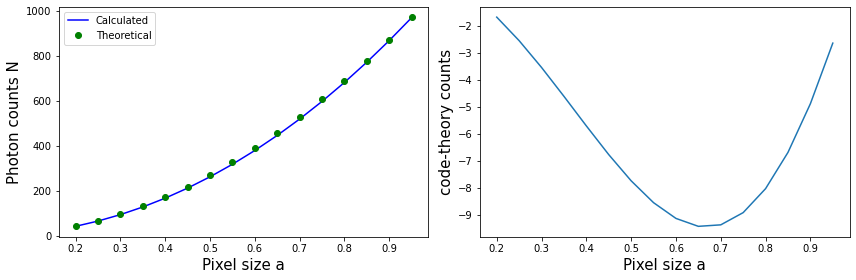

In [4]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(pixelsize,m,"b", label="Calculated")
ax[0].plot(pixelsize,mT,"go", label="Theoretical")
ax[0].set_xlabel("Pixel size a")
ax[0].set_ylabel("Photon counts N")
ax[0].legend()

ax[1].plot(pixelsize, m-mT)
ax[1].set_xlabel("Pixel size a")
ax[1].set_ylabel("code-theory counts")
fig.tight_layout()

photon count code: 43.0388
photon count true: 43.0400
alpha=0.33, beta=0.50, gamma=-0.00, xmax=24, a=0.2, bg=1, rotation=0.0Pi


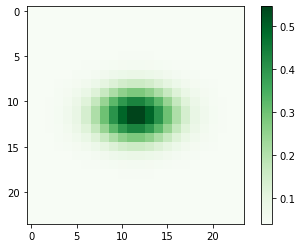

In [5]:
def para(a,b,theta):
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma

theta = np.pi/4*0
n = 20
alpha0 = 3
beta0 = 2
alpha,beta,gamma = para(1/alpha0,1/beta0,theta)
xmax = 3*8
ymax = xmax
thetaX = (xmax-1)/2
thetaY = thetaX
a = 0.2
thetabg = 1
numSteps = 30


N = 500
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
m = mu(xs, ys, thetaX, thetaY, N,a,numSteps,alpha,beta,gamma,thetabg)
plt.imshow(m,cmap="Greens")
plt.colorbar();

print(f'photon count code: {np.sum(m):.4f}')
print(f'photon count true: {a**2*thetabg*xmax**2+N*a**2:.4f}')
print(f"alpha={alpha:.2f}, beta={beta:.2f}, gamma={gamma:.2f}, xmax={xmax}, a={a}, bg={thetabg}, rotation={theta/np.pi}Pi")